In [2]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

Created WidebandSignal with 1.0 MHz total bandwidth and 100000 samples per step.


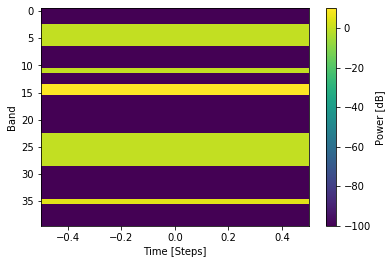

Signal power: 15.34 dB
Noise power:  -0.02 dB
SNR:          15.35 dB
Num samples:  100000 


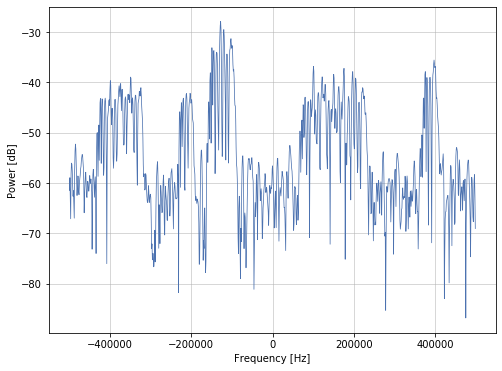

In [53]:
# general settings for signal and noise
length = 0.1  # in s
noise_power = 0.0  # in dB

num_bands = 40

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length,
                        num_bands=num_bands,
                        num_steps=1,
                        band_width=0.25e5)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100], [-100], [-100], [0], [0], [0], [0], [-100], [-100],
                [-100], [-100], [0], [-100], [-100], [10], [10], [-100], [-100],
                [-100], [-100], [-100], [-100], [-100], [0], [0], [0], [0], [0], [0],
                [-100], [-100], [-100], [-100], [-100], [-100], [5], [-100], [-100],
                [-100], [-100]])

# plot the matrix
wbs.plot(mat)

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

# use the 1d plot function to plot the power spectral density
ss.spectrum_plot_1d(sig=both[1024:2048],
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024)

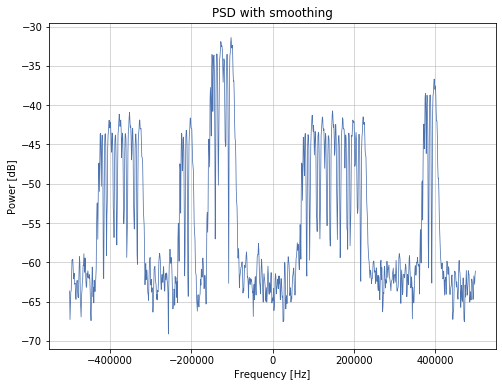

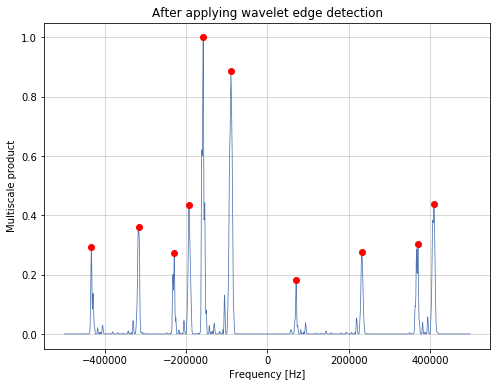

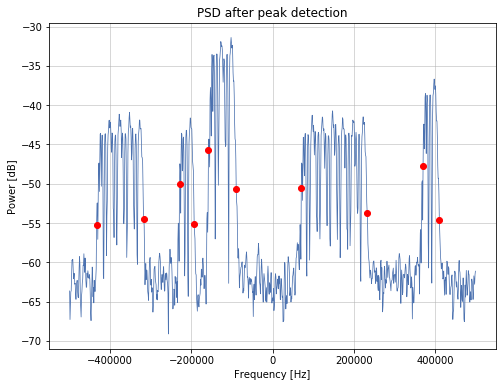

In [59]:
# create a Short Time Fourier Transform object
sft = ss.Stft(n=1024, window='flattop')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

# smooth the spectrum by averaging (Bartlett's method)
psd = ss.util_wide.psd_average(spectogram=x, start=10, stop=20)

# detect edges in spectrum
prod, peak, peakf = ss.edge_detector(
    psd,
    f,
    scale=4,  # number of multi-scale wavelet products
    min_height=0.1,  # min height required
    min_freq=2e4)  # min frequency spacing required

plt.figure(figsize=(8, 6))
plt.title('PSD with smoothing')
plt.plot(f, psd, linewidth=0.75, aa=True)
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Power [dB]")
plt.grid(linewidth=0.5)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('After applying wavelet edge detection')
plt.plot(f, prod, linewidth=0.75, aa=True)
plt.plot(peakf, prod[peak], 'ro')
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Multiscale product")
plt.grid(linewidth=0.5)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('PSD after peak detection')
plt.plot(f, psd, linewidth=0.75, aa=True)
plt.plot(peakf, psd[peak], 'ro')
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"Power [dB]")
plt.grid(linewidth=0.5)
plt.show()